<a href="https://colab.research.google.com/github/vitthal-bhandari/Text-Classification/blob/master/TextClassificationDistilBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Environment Check**

In [1]:
#check gpu usage
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Feb  8 16:43:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#check ram usage
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
!pip install datasets

     |████████████████████████████████| 311 kB 4.3 MB/s 
     |████████████████████████████████| 1.1 MB 51.3 MB/s 
     |████████████████████████████████| 133 kB 66.4 MB/s 
     |████████████████████████████████| 243 kB 62.9 MB/s 
     |████████████████████████████████| 67 kB 5.1 MB/s 
     |████████████████████████████████| 94 kB 2.8 MB/s 
     |████████████████████████████████| 271 kB 59.1 MB/s 
     |████████████████████████████████| 144 kB 57.5 MB/s 


# **Import the "emotion" Dataset**

In [4]:
from datasets import load_dataset

emotions = load_dataset('emotion')

Downloading:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.61k [00:00<?, ?B/s]

Using custom data configuration default


Downloading: 0.00B [00:00, ?B/s]

Downloading: 0.00B [00:00, ?B/s]

Downloading: 0.00B [00:00, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

# **Inspect the dataset**

In [6]:
train_ds = emotions['train']
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [7]:
train_ds.column_names

['text', 'label']

In [8]:
train_ds[0]

{'label': 0, 'text': 'i didnt feel humiliated'}

In [9]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(num_classes=6, names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], names_file=None, id=None)}


# **Create dataframe**

In [10]:
import pandas as pd

emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [11]:
def label_int2str(row):
  return emotions["train"].features["label"].int2str(row)
df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


# **Examine Class Distribution**

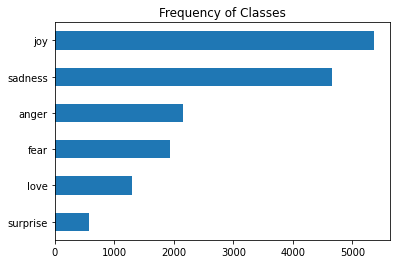

In [12]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

# **Examine Tweet Length**

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


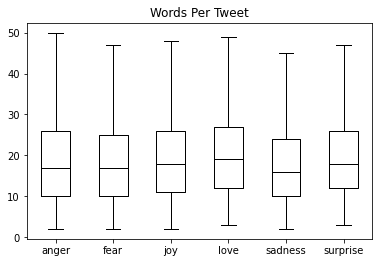

In [13]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

**Reset Output Format**

In [14]:
emotions.reset_format()

# **Tokenization**

In [15]:
!pip install transformers

     |████████████████████████████████| 3.5 MB 4.1 MB/s 
     |████████████████████████████████| 596 kB 62.9 MB/s 
     |████████████████████████████████| 895 kB 64.6 MB/s 
     |████████████████████████████████| 6.8 MB 50.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [16]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [17]:
def tokenize(batch):
  return tokenizer(batch["text"], padding=True, truncation=True)

In [18]:
#apply tokenizer across all splits in the corpus
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [19]:
emotions_encoded["train"].column_names

['text', 'label', 'input_ids', 'attention_mask']

In [20]:
emotions_encoded["train"][0]

{'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'input_ids': [101,
  1045,
  2134,
  2102,
  2514,
  26608,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'label': 0,
 'text': 'i didnt feel humiliated'}

# **Training the Classifier with Feature Extraction**

In [21]:
!pip3 install torch==1.10.2+cu102 torchvision==0.11.3+cu102 torchaudio===0.10.2+cu102 -f https://download.pytorch.org/whl/cu102/torch_stable.html

Looking in links: https://download.pytorch.org/whl/cu102/torch_stable.html
     |██████████████████████████████▎ | 834.1 MB 1.2 MB/s eta 0:00:40tcmalloc: large alloc 1147494400 bytes == 0x55eb22102000 @  0x7f51ba5ed615 0x55eae94fa3bc 0x55eae95db18a 0x55eae94fd1cd 0x55eae95efb3d 0x55eae9571458 0x55eae956c02f 0x55eae94feaba 0x55eae95712c0 0x55eae956c02f 0x55eae94feaba 0x55eae956dcd4 0x55eae95f0986 0x55eae956d350 0x55eae95f0986 0x55eae956d350 0x55eae95f0986 0x55eae956d350 0x55eae94fef19 0x55eae9542a79 0x55eae94fdb32 0x55eae95711dd 0x55eae956c02f 0x55eae94feaba 0x55eae956dcd4 0x55eae956c02f 0x55eae94feaba 0x55eae956ceae 0x55eae94fe9da 0x55eae956d108 0x55eae956c02f
     |████████████████████████████████| 881.9 MB 2.0 kB/s 
     |████████████████████████████████| 23.2 MB 59.1 MB/s 
     |████████████████████████████████| 2.9 MB 20.8 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch

In [22]:
import torch

In [23]:
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [24]:
device

device(type='cuda')

In [25]:
def extract_hidden_states(batch):
  #place model inputs on the GPU
  inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
  #extract last hidden states
  with torch.no_grad():
    last_hidden_state = model(**inputs).last_hidden_state
    #return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:, 0].cpu().numpy()}

In [26]:
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])

In [27]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [28]:
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [29]:
import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

In [30]:
!pip install umap-learn

     |████████████████████████████████| 86 kB 2.8 MB/s 
     |████████████████████████████████| 1.1 MB 23.1 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82708 sha256=f8f010cd559575562b181b4987fd759a42b11ac390595dba137b04fc397f5e32
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=7e81275cdec911821098d98d25a871f528e08c506bfe58bd86bb68b859429ff2
  Stored in directory: /root/.cache/pip/wheels/03/f1/56/f80d72741e400345b5a5b50ec3d929aca581bf45e0225d5c50
Successfully built umap-learn pynndescent


In [31]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


,X,Y,label
0,4.411687,6.566739,0
1,-2.748102,6.229320,0
2,5.247741,2.912323,3
3,-2.572990,3.681889,2
4,-3.221592,4.168924,3


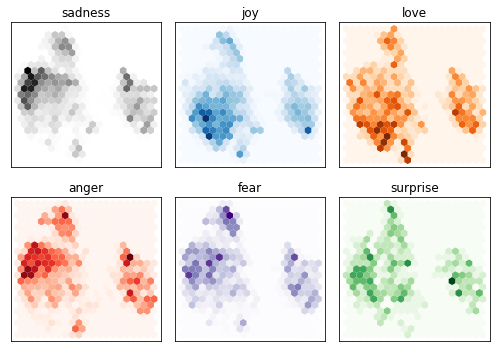

In [32]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

In [33]:
from sklearn.linear_model import LogisticRegression

# We increase `max_iter` to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.633

In [34]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

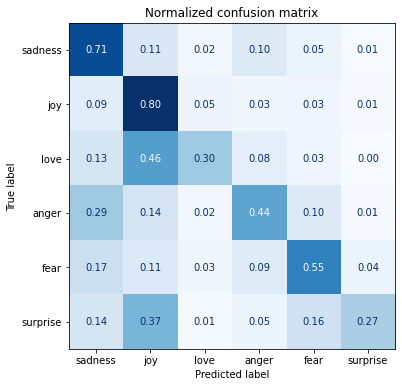

In [35]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

# **Training the Classifier with Fine-Tuning**

In [36]:
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'classifi

In [37]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average='weighted')
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

In [38]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [42]:
from transformers import Trainer, TrainingArguments

batch_size = 32
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f'{model_ckpt}-finetuned-emotion'
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  log_level="error")

In [44]:
!curl -s https://packagecloud.io/install/repositories/github/git-lfs/script.deb.sh | sudo bash
!sudo apt-get install git-lfs
!git lfs install

Detected operating system as Ubuntu/bionic.
Checking for curl...
Detected curl...
Checking for gpg...
Detected gpg...
Running apt-get update... done.
Installing apt-transport-https... done.
Installing /etc/apt/sources.list.d/github_git-lfs.list...done.
Importing packagecloud gpg key... done.
Running apt-get update... done.

The repository is setup! You can now install packages.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  cuda-command-line-tools-10-0 cuda-command-line-tools-10-1
  cuda-command-line-tools-11-0 cuda-compiler-10-0 cuda-compiler-10-1
  cuda-compiler-11-0 cuda-cuobjdump-10-0 cuda-cuobjdump-10-1
  cuda-cuobjdump-11-0 cuda-cupti-10-0 cuda-cupti-10-1 cuda-cupti-11-0
  cuda-cupti-dev-11-0 cuda-documentation-10-0 cuda-documentation-10-1
  cuda-documentation-11-0 cuda-documentation-11-1 cuda-gdb-10-0 cuda-gdb-10-1
  cuda-gdb-11-0 cuda-gpu-library-ad

In [45]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

Cloning https://huggingface.co/bitsanlp/distilbert-base-uncased-finetuned-emotion into local empty directory.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.617600,0.216297,0.919000,0.918443
2,0.173700,0.173022,0.936000,0.936384


In [46]:
preds_output = trainer.predict(emotions_encoded["validation"])

In [47]:
preds_output.metrics

{'test_accuracy': 0.936,
 'test_f1': 0.93638400406839,
 'test_loss': 0.17302173376083374,
 'test_runtime': 3.1937,
 'test_samples_per_second': 626.226,
 'test_steps_per_second': 19.726}

In [48]:
y_preds = np.argmax(preds_output.predictions, axis=1)

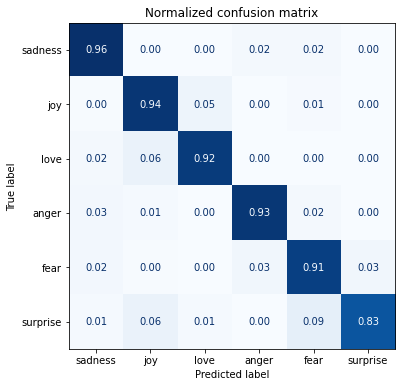

In [49]:
plot_confusion_matrix(y_preds, y_valid, labels)

# **Saving and sharing the model**

In [51]:
!pip install --upgrade pyyaml

In [ ]:
trainer.push_to_hub(commit_message="Training completed!")